## Imports

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Variable

from sklearn.model_selection import train_test_split
from copy import copy

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [12]:
np.random.seed(42)
torch.manual_seed(42)

## Load data

In [13]:
digits_bunch = load_digits()
digits_df = pd.DataFrame(digits_bunch.data)
digits_df['target'] = pd.Series(pd.Categorical.from_codes(digits_bunch.target, categories=digits_bunch.target_names))

In [14]:
X, y = digits_df.drop('target', axis=1), digits_df['target']
print('X shape: {}, y shape: {}'.format(X.shape, y.shape))

X shape: (1797, 64), y shape: (1797,)


In [15]:
X, y = X.values, y.values
y = y.astype(int)
X = X / 16

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [20]:
X_train.shape

(1437, 64)

In [ ]:
BATCH_SIZE = 32

torch_X_train = torch.from_numpy(X_train).type(torch.FloatTensor)
torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor)

torch_X_test = torch.from_numpy(X_test).type(torch.FloatTensor)
torch_y_test = torch.from_numpy(y_test).type(torch.LongTensor)

train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = True)

## Model

In [23]:
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Model training

In [26]:
model = MLP(input_size=64)
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_function = nn.CrossEntropyLoss()

losses = []
epochs = 100
for epoch in range(epochs):
    total = 0
    for batch in iter(train_loader):
        X_, y_ = batch
        y_hat = model(X_)
        
        loss = loss_function(y_hat, y_.long())
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        total += loss.item()
        
    losses.append(total)

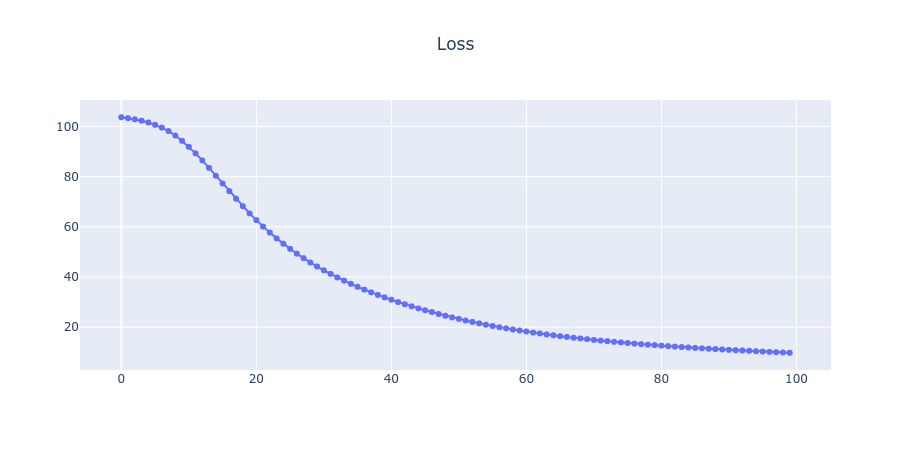

In [29]:
fig = make_subplots(rows=1, cols=1, subplot_titles=(""))  
    
fig.append_trace(go.Scatter(
    x=np.arange(epochs),
    y=losses, name="iter", mode='lines+markers'), row=1, col=1)

fig.update_layout(height=450, width=900, title_text="Loss", 
                  showlegend=False, title_x=0.5)
fig.show()

In [42]:
def get_confusion_matrix(X, y):
    model.eval()
    pred = model(X)
    y_pred = np.argmax(F.softmax(pred, dim=1).detach().numpy(), axis=1)
    
    print(f"Accuracy: {accuracy_score(y_pred, y)}")
    print(f"Confusion matrix:\n {confusion_matrix(y_pred, y)}")

In [43]:
get_confusion_matrix(torch_X_test, torch_y_test)

Accuracy: 0.9194444444444444
Confusion matrix:
 [[35  0  0  0  0  0  0  0  0  0]
 [ 0 25  0  0  0  0  0  0  7  0]
 [ 0  0 35  0  0  0  0  0  0  0]
 [ 0  0  0 36  0  0  0  0  0  1]
 [ 1  1  0  0 35  0  0  2  0  1]
 [ 0  0  0  0  0 37  0  0  0  0]
 [ 0  5  0  0  1  0 36  0  0  0]
 [ 0  0  0  0  0  0  0 34  1  2]
 [ 0  0  0  0  0  0  0  0 27  1]
 [ 0  5  0  1  0  0  0  0  0 31]]


## Attack

In [44]:
def attack_on_mnist(digit=8, n=64, n_classes=10, eta=0.01, epochs=100):
    
    y = torch.tensor([digit]).long()
    x = torch.tensor(np.random.normal(loc=0, scale=0.01, size=n)).float()
    
    for epoch in range(epochs): 
        x = Variable(x.data.clone(), requires_grad=True)
        y_hat = model(x).unsqueeze(0)
        loss = loss_function(y_hat, y)

        model.zero_grad()
        loss.backward()
        grad = x.grad.data

        x = torch.clamp(x - eta * grad.sign(), 0, 1)
        
    alpha = 0.5
    X_spoiled = np.maximum(X_test.copy() * (1 - alpha), alpha * x.detach().numpy())

    torch_X_spoiled = torch.from_numpy(X_spoiled).type(torch.FloatTensor)
    
    return torch_X_spoiled

In [45]:
torch_X_spoiled = attack_on_mnist()

In [46]:
get_confusion_matrix(torch_X_spoiled, y_test)

Accuracy: 0.10277777777777777
Confusion matrix:
 [[ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [36 36 35 37 34 37 36 36 35 36]
 [ 0  0  0  0  0  0  0  0  0  0]]
